# Assignement 2

This is your second assignement in the computer vision course. This time you are supposed to implement a system that outputs bounding boxes (bb) of pedestrians.

**Bounding box definition:** the smallest axis aligned rectangle containing all the pixels of the pedestrian

Ouput format:
 - A list of [frame_id, bb_id, x, y, dx, dy]. See prenom_nom.py module for an example
 
Evaluation function:
 - Detections are converted into binary masks and we calculate the following metrics: intersecion over union. Note that this metric is not sensitive to the number of bb-s. You can find the code below for the evaluation.
 - The evaluation will be performed in an independent video sequence.
 
Scoring:
 - Your work will be evaluated as usual (complexity of the solution, clean implementation, well documented) **PLUS** the best 5 will receive +1 for the grade of the assignement.
 
You have to handle in:
 - Your code that is a single python module (possibly with requirements.txt or with a dockerfile). See the example prenom_nom.py. It has to implement the same interface, if it fails to run, your solution is considered failing.
 - Your report. Short summary of your algorithm, motivation for the algorithm used, failing cases, code and results (~1 page).
 
You should send your assignment by mail to maria.vakalopoulou@centralesupelec.fr, the name of the subject of the mail should be: VIC_Assignement2_name
 

In [19]:
data_root = './img1/'
gt_path = './gt/gt.txt'

In [38]:
import yahya

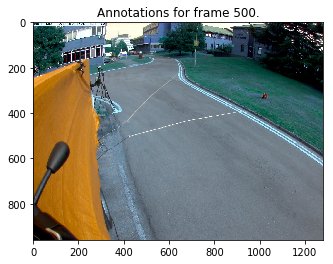

A great score! 1.0


In [9]:
%matplotlib inline
from matplotlib import pyplot as plt
import cv2
import os
import numpy as np
import yahya


data_root = './img1/'
gt_path = './gt/gt.txt'

_W = 1280
_H = 960
_N = 684 # number of frames

def format_id(frame):
    assert _N >= frame
    return '{:03d}'.format(frame)


def read_frame(root, frame):
    """Read frames and create integer frame_id-s"""
    assert _N >= frame
    return cv2.imread(os.path.join(root,format_id(frame)+'.jpg'), cv2.IMREAD_UNCHANGED)
    

def read_gt(filename):
    """Read gt and create list of bb-s"""
    assert os.path.exists(filename)
    with open(filename, 'r') as file:
        lines = file.readlines()
    # truncate data (last columns are not needed)
    return [list(map(lambda x: int(x), line.split(',')[:6])) for line in lines]


def annotations_for_frame(solution, frame):
    assert _N >= frame
    return [bb for bb in solution if int(bb[0])==int(frame)]


def evaluate_solution(gt, solution, N):
    """Caclulate evaluation metric"""
    score = []
    #for frame in [300]:
    for frame in range(1, N):
        bbs_sol = annotations_for_frame(solution, frame)
        bbs_gt = annotations_for_frame(gt, frame)
        black_sol = np.zeros((_H, _W))
        black_gt = np.zeros((_H, _W))
        for bb in bbs_sol:
            x, y = bb[2:4]
            dx, dy = bb[4:6]
            cv2.rectangle(black_sol, (x, y), (x+dx, y+dy), (255), -1)
        for bb in bbs_gt:
            x, y = bb[2:4]
            dx, dy = bb[4:6]
            cv2.rectangle(black_gt, (x, y), (x+dx, y+dy), (255), -1)
        # intersection over union
        intersection = black_sol * black_gt
        intersection[intersection > 0.5] = 1
        union = black_sol + black_gt
        union[union > 0.5] = 1
        if not union.any():
            continue
        score.append(intersection.sum()/union.sum())
        
        
    return np.asarray(score).mean()
    

def show_annotation(solution, frame):
    assert _N >= frame
    im = read_frame(data_root, frame)
    bbs = annotations_for_frame(solution, frame)
    for bb in bbs:
        x, y = bb[2:4]
        dx, dy = bb[4:6]
        cv2.rectangle(im, (x, y), (x+dx, y+dy), (0,255,0), 10)
    plt.imshow(im)
    plt.title('Annotations for frame {}.'.format(frame))
    plt.show()
    return

gt = read_gt(gt_path)

show_annotation(gt, 500)

#print('A perfect score... {}'.format(evaluate_solution(gt, gt, _N)))

# your solution will be tested simply by changing the dataset
# and changing the module, i.e., the following has to work 
# with simply using your module

sol = yahya.pedestrians(data_root,_W, _H, _N)
print('A great score! {}'.format(evaluate_solution(gt, sol, _N)))



# Importing Necessary libraries and elements

In [10]:
%matplotlib inline
from matplotlib import pyplot as plt
import cv2
import os
import numpy as np
import yourname
import imageio
import pandas as pd 
from skimage.feature import hog  
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils.multiclass import unique_labels

# Creating train and test set

### Importing images

In [11]:
link_pos_train = './INRIAPerson/train_64x128_H96/pos/'
link_neg_train = './INRIAPerson/train_64x128_H96/neg/'
link_pos_test = './INRIAPerson/test_64x128_H96/pos/'
link_neg_test = './INRIAPerson/test_64x128_H96/neg/'

In [12]:
def create_set (link):
    im_list = [os.path.join(link, file) for file in os.listdir(link)]
    ims = []
    for elmnt in im_list:
        if elmnt.endswith(".jpg") : 
            img = cv2.imread(elmnt, cv2.IMREAD_UNCHANGED)
            ims.append(img)
        elif elmnt.endswith(".png"): 
            img = imageio.imread(elmnt)
            #convert image to cv2 
            img_cv2 = img[:, :, :3]
            ims.append(img_cv2)
    print ('number of images loaded : {}'.format(len(ims)))
    return ims

In [13]:
train_pos = create_set (link_pos_train)
train_neg = create_set (link_neg_train)
test_pos = create_set (link_pos_test)
test_neg = create_set (link_neg_test)

number of images loaded : 2416
number of images loaded : 1218
number of images loaded : 1126
number of images loaded : 453


### Creating labels

In [14]:
train_pos_lab = np.ones(len(train_pos)).tolist()
train_neg_lab = np.zeros(len(train_neg)).tolist()
test_pos_lab = np.ones(len(test_pos)).tolist()
test_neg_lab = np.zeros(len(test_neg)).tolist()

In [15]:
train_set = zip (train_pos  + train_neg , train_pos_lab  + train_neg_lab)
test_set = zip (test_pos + test_neg , test_pos_lab + test_neg_lab)

### Shuffling element

In [16]:
from random import shuffle
shuffle(train_set)
shuffle(test_set)

In [17]:
train_set_df = pd.DataFrame(train_set , columns = ['Image','Label'])
test_set_df = pd.DataFrame(test_set, columns = ['Image','Label'])

In [18]:
Y_train = train_set_df['Label']
Y_test = test_set_df['Label']

## Extracting HOG features 

In [19]:
def extract_hog (dataset, resize = True,  input_dim = (96,160), printing = True, include_label = True ) : 
    hog_features = []
    for i in range (len(dataset)) : 
        if include_label : 
            if resize : 
                if dataset[i][0].shape[0] != input_dim[1] or dataset[i][0].shape[1] != input_dim[0]: 
                    resized_im = cv2.resize(dataset[i][0], input_dim ,interpolation=cv2.INTER_AREA)
                else : 
                    resized_im = dataset[i][0]
                features = hog(resized_im , orientations=9, pixels_per_cell=(20, 20), cells_per_block=(2, 2), block_norm='L2-Hys' , visualize=False, visualise=None, transform_sqrt=False, feature_vector=True, multichannel=None)
                hog_features.append(features)
            else : 
                features = hog(dataset[i][0] , orientations=9, pixels_per_cell=(20, 20), cells_per_block=(2, 2), block_norm='L2-Hys' , visualize=False, visualise=None, transform_sqrt=False, feature_vector=True, multichannel=None)
                hog_features.append(features)
        else : 
            if resize : 
                if dataset[i].shape[0] != input_dim[1] or dataset[i].shape[1] != input_dim[0]: 
                    resized_im = cv2.resize(dataset[i], input_dim ,interpolation=cv2.INTER_AREA)
                else : 
                    resized_im = dataset[i]
                features = hog(resized_im , orientations=9, pixels_per_cell=(20, 20), cells_per_block=(2, 2), block_norm='L2-Hys' , visualize=False, visualise=None, transform_sqrt=False, feature_vector=True, multichannel=None)
                hog_features.append(features)
            else : 
                features = hog(dataset[i] , orientations=9, pixels_per_cell=(20, 20), cells_per_block=(2, 2), block_norm='L2-Hys' , visualize=False, visualise=None, transform_sqrt=False, feature_vector=True, multichannel=None)
                hog_features.append(features)
        if printing :
            if i % 1000 == 0 : 
                print ("number of image processed {} ".format(i))
    if printing :
        print ("shape of HOG features per image {} :".format(np.array(features).shape))
    return hog_features

In [20]:
hog_train = extract_hog (train_set)
hog_test = extract_hog (test_set)

number of image processed 0 
number of image processed 1000 
number of image processed 2000 
number of image processed 3000 
shape of HOG features per image (756,) :
number of image processed 0 
number of image processed 1000 
shape of HOG features per image (756,) :


In [21]:
X_train = hog_train
X_test = hog_test

# Classification using SVM

## First training

In [22]:
svm = SVC(C=25.0, kernel='rbf', degree=5,
    coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight="balanced",
    verbose=False, max_iter=-1, decision_function_shape='ovr', random_state=None)

In [23]:
svm.fit(X_train, Y_train)

/Users/lazraq/anaconda2/lib/python2.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=25.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=5, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [24]:
prediction = svm.predict(X_test)

In [25]:
accuracy_score(Y_test, prediction)

0.9417352754908169

In [26]:
confusion_matrix(Y_test, prediction)

array([[ 434,   19],
       [  73, 1053]])

## Hard Negative minning

## First iteration

In [27]:
all_negative = train_neg + test_neg

In [28]:
def moving_window(image, step, window_shape):
    for y in range(0, image.shape[0], step):
        for x in range(0, image.shape[1], step):   
            yield (x, y, image[y:min(y + window_shape[1],image.shape[0]),
                               x:min(x + window_shape[0],image.shape[1])])

In [29]:
def extract_missclassified (all_negative, model): 
    false_pos_im = []
    count = 0
    all_pics = []
    false_pos_hog = []
    for neg in all_negative : 
        #variant_size = [(50, 50), (100,100), (150,150), (200,200), (250,250), (300,300), (350,350), (400,400), (500, 500), (600,600)]
        variant_size = [(50, 50),(75, 75),(100,100), (150,150),(200,200), (300,300), (125,125)]
        for (dx,dy) in variant_size:
            for (x, y, new_window) in moving_window(neg, step=100, window_shape=(dx,dy)):
                all_pics.append (new_window)
                window_feature = extract_hog ([new_window], printing = False,include_label = False)[0].reshape(-1, 1).T
                prediction = int(model.predict(window_feature))
                if prediction == 1:
                    false_pos_im.append(new_window)
                    false_pos_hog.append(window_feature[0])
        count += 1
        if count % 100 == 0 : 
            print ("number of image processed {} ".format(count))                
    return false_pos_hog, false_pos_im , all_pics

In [30]:
false_pos_hog, false_pos_im , all_pics = extract_missclassified (all_negative, svm)

number of image processed 100 
number of image processed 200 
number of image processed 300 
number of image processed 400 
number of image processed 500 
number of image processed 600 
number of image processed 700 
number of image processed 800 
number of image processed 900 
number of image processed 1000 
number of image processed 1100 
number of image processed 1200 
number of image processed 1300 
number of image processed 1400 
number of image processed 1500 
number of image processed 1600 


In [31]:
X_train_false = X_train + false_pos_hog
Y_false_pos = np.zeros(len(false_pos_im)).tolist()
Y_train_false = np.array(Y_train.tolist() + Y_false_pos)

In [32]:
svm.fit(X_train_false, Y_train_false)

SVC(C=25.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=5, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [33]:
prediction = svm.predict(X_test)

In [34]:
accuracy_score(Y_test, prediction)

0.8815706143128562

In [35]:
confusion_matrix(Y_test, prediction)

array([[412,  41],
       [146, 980]])

## Second iteration

In [36]:
false_pos_hog_2, false_pos_im_2 , all_pics_2 = extract_missclassified (all_negative, svm)

number of image processed 100 
number of image processed 200 
number of image processed 300 
number of image processed 400 
number of image processed 500 
number of image processed 600 
number of image processed 700 
number of image processed 800 
number of image processed 900 
number of image processed 1000 
number of image processed 1100 
number of image processed 1200 
number of image processed 1300 
number of image processed 1400 
number of image processed 1500 
number of image processed 1600 


In [37]:
X_train_false_2 = X_train_false + false_pos_hog_2

In [38]:
Y_false_pos_2 = np.zeros(len(false_pos_im_2)).tolist()

In [39]:
Y_train_false_2 = np.array(Y_train_false.tolist() + Y_false_pos_2)

In [40]:
svm.fit(X_train_false_2 , Y_train_false_2 )

SVC(C=25.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=5, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [41]:
prediction_2 = svm.predict(X_test)

In [42]:
accuracy_score(Y_test, prediction_2)

0.8879037365421153

# Pedestrian detection on given dataset 

## Analyse for one picture

In [43]:
from imutils.object_detection import non_max_suppression

In [48]:
img = cv2.imread(os.path.join(data_root,format_id(300)+'.jpg'), cv2.IMREAD_UNCHANGED)

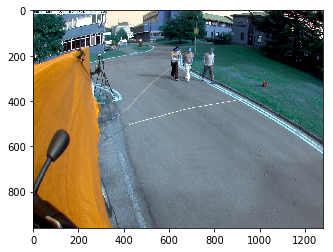

In [49]:
plt.imshow(img)

In [54]:
img_x = img.shape[1]
img_y = img.shape[0]
boxes = []
orig_1 = img.copy()
orig_2 = img.copy()
#scale = [7,13,18]
scale = [18]
for i in scale : 
    dx = int(img_x/i)
    dy = int(2.7* dx)
    for (x, y, new_window) in moving_window(img, step= 30, window_shape=(dx,dy)):
        window_feature = extract_hog ([new_window], printing = False,include_label = False)[0].reshape(-1, 1).T
        prediction = int(svm.predict(window_feature))
        if prediction == 1:
            boxes.append([x,y,dx,dy])
rects = np.array([[x, y, x + w, y + h] for (x, y, w, h) in boxes])
for (x, y, w, h) in rects:
        cv2.rectangle(orig_1, (x, y), (w, h), (0, 0, 255), 2)
pick = non_max_suppression(rects, probs=None, overlapThresh=0.65)
for (xA, yA, xB, yB) in pick:
    cv2.rectangle(orig_2, (xA, yA), (xB, yB), (0, 255, 0), 2)

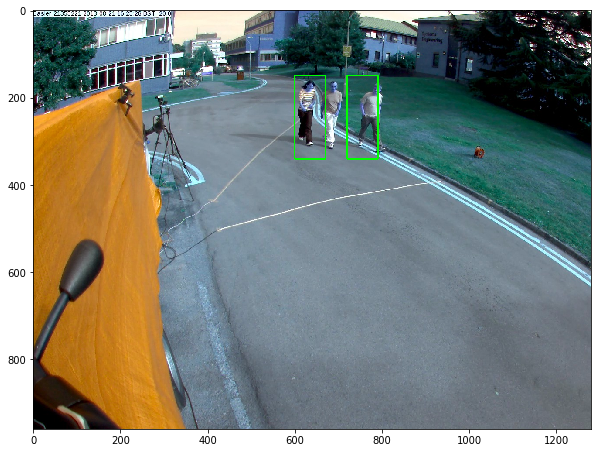

In [55]:
plt.figure(figsize=(10, 10))
plt.imshow(orig_2)

## All frame analysis

In [ ]:
def pedestrian (model, root = data_root, size_test = _N) : 
    boxes = []
    #window_sizes = [(50,70), (100, 140),(150, 210)]
    #scale = [7,13,18]
    scale = [18]
    for j in range (1,size_test):
        boxe_temp = []
        img = cv2.imread(os.path.join(data_root,format_id(j)+'.jpg'), cv2.IMREAD_UNCHANGED)
        img_x = img.shape[1]
        img_y = img.shape[0]
        for i in scale : 
            dx = int(img_x/i)
            dy = int(2.5* dx)
            for (x, y, new_window) in moving_window(img, step=40 , window_shape=(dx,dy)):
                window_feature = extract_hog ([new_window], printing = False,include_label = False)[0].reshape(-1, 1).T
                prediction = int(model.predict(window_feature))
                if prediction == 1:
                    boxe_temp.append([x,y,dx,dy])
        rects = np.array([[x, y, x + w, y + h] for (x, y, w, h) in boxe_temp])
        pick = non_max_suppression(rects, probs=None, overlapThresh=0.65)
        if pick != [] : 
            for (xA, yA, xB, yB) in pick: 
                boxes.append([j,j,xA, yA, xB-xA, yB-yA])
        else : 
            boxes.append([j,j,0,0,0,0])
        if j % 20 == 0 : 
                print ("number of image processed {} ".format(j))
    return boxes

In [ ]:
pedestrian_boxes = pedestrian (svm, root = data_root, size_test =_N)

In [ ]:
evaluate_solution(gt, pedestrian_boxes, _N)